    Documentation
    Visualizations

    Regression model for comparison
    RandomForest hyperparameters
    XGBoost implementation and hyperparameters

    (Train/validation cross validation implementation)

# Import libraries

In [2]:
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
# custom classes
from preprocessing import Merger, Imputer, Cleaner
%matplotlib inline


# Load data

<font color='red'>For now we are ignoring the holdout data.</font>

In [3]:
store_data = pd.read_csv("./data/store.csv")
sales_data = pd.read_csv("./data/train.csv")
# holdout_data = pd.read_csv("./data/holdout.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Preprocessing of data

## Merging tables

Our store information is separate from our sales information. In our Merger object we perform multiple operations:
* Drop sales data where sales is NaN or 0.
* Drop the customers column because of its direct relation to sales and its unknown value when predicting the future.
* Combine sales and store data into a single table by joining on the store ID.
* All stores without and ID, i.e., the NaNs, are given the label 0. This label was not in use as a store ID.

<font color='red'>We need to decide what to do with the holdout and how to cross validate</font>

In [4]:
mrg = Merger()
mrg.merge(sales_data, store_data)
merged_data = mrg.merged_data

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
print(f"We have {len(merged_data)} samples to work with.")
merged_data.sample(5)

We have 512956 samples to work with.


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
455106,2014-05-22,986,4.0,5959.0,1.0,NaN,0,0.0,a,a,620.0,10.0,2014.0,1.0,18.0,2014.0,"Feb,May,Aug,Nov"
430099,2014-04-24,1039,4.0,5658.0,1.0,0.0,0,1.0,a,c,70.0,6.0,1990.0,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
411674,2014-04-02,571,3.0,7199.0,1.0,1.0,0.0,0.0,d,a,2110.0,11.0,1995.0,1.0,40.0,2014.0,"Jan,Apr,Jul,Oct"
508512,2014-07-26,556,6.0,5599.0,1.0,0.0,0,0.0,d,c,1140.0,11.0,2014.0,0.0,NaN,NaN,NaN
36057,2013-02-09,145,6.0,6969.0,1.0,0.0,0,0.0,a,a,280.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov"


In [6]:
duped_mask = merged_data.duplicated()
duplicated_data = merged_data.loc[duped_mask, :]

print(f"There are {len(duplicated_data)} duplicated values in our dataset.")
print(f"This is a low number compared to the {len(merged_data)} samples in our dataset.")
print("These duplicates are not necessarily 'true' because the store ID is not known.")
print("Therefore these duplicates may actually be two shops having the exact same sales on a single day.")
print("Because of this uncertainty we are keeping the duplicates in our dataset.")

There are 30 duplicated values in our dataset.
This is a low number compared to the 512956 samples in our dataset.
These duplicates are not necessarily 'true' because the store ID is not known.
Therefore these duplicates may actually be two shops having the exact same sales on a single day.
Because of this uncertainty we are keeping the duplicates in our dataset.


In [7]:
# columns = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday',
#        'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
#        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
#        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
# merged_time_series = merged_data.drop(columns, axis=1, inplace=True)

In [8]:
# #merged_data date column to datetime and to week and year column
# def date_to_week(df):
#     df['Date'] = pd.to_datetime(df['Date'])
#     df['Week'] = df['Date'].dt.week
#     df['Year'] = df['Date'].dt.year
#     return df

# date_to_week(merged_data)

# #merged_data merge week and year column
# def merge_week_year(df):
#     # df["Week"] = df["Week"].astype(int)
#     # df["Year"] = df["Year"].astype(int)
#     df["WeekOfYear"] = df["Year"].astype(str) + "/" + df["Week"].astype(str)
#     return df

# merge_week_year(merged_data)


In [9]:
# # plotly plot sales per storetype per date
# def plot_sales_per_storetype_per_date(merged_data):
#     fig = plt.figure(figsize=(12, 8))
#     sns.set(style="whitegrid")
#     sns.lineplot(x="Date", y="Sales", hue="StoreType", data=merged_data)
#     plt.show()

# plot_sales_per_storetype_per_date(merged_data)


In [10]:
# # plotly plot sales per storetype per date group by year-week 
# def plot_sales_per_storetype_per_date_group_by_week(merged_data):
#     fig = plt.figure(figsize=(12, 8))
#     sns.set(style="whitegrid")
#     sns.lineplot(x="WeekOfYear", y="Sales", hue="StoreType", data=merged_data)
#     plt.show()

# plot_sales_per_storetype_per_date_group_by_week(merged_data)

In [11]:
# plotly plot sales per storetype per date group by year-week 
# def 

In [12]:
# plot merged_data by 
# merged_data.groupby(['StoreType', 'Date']).Sales.mean().plot(x='Date', y='Sales', kind='line')


In [13]:
# merged_data.groupby(by = "Sales").mean().plot(kind = "line")

#merged_data.plot(x = 'Date', y = (merged_data.groupby(['Sales'].mean())))

In [14]:
# merged_time_series

In [15]:
# sns.lineplot(x="Date", y="Sales", data=merged_data);

In [16]:
# plot merged_data Sales column with Stores lineplot
# sns.lineplot(data=merged_data, x="Date", y="StoreType")

## Splitting train, validation, and test sets

Before continuing we need to split our test and training sets. Because we are dealing with time-series data, we split on data before and after specific dates.

<font color='red'>We are currently splitting train, validation, and test. Are we doing cross validation? How? How should we be splitting? Once decided, also update all names in notebook.</font>

In [17]:
print(f"The last day in our data is {merged_data['Date'].max()}")

The last day in our data is 2014-07-31


In [18]:
test_date_split = '2014-04-31'
validation_date_split = '2014-01-31'

In [19]:
merged_data_train = merged_data.query("Date <= @validation_date_split")
merged_data_validation = merged_data.query("Date > @validation_date_split & Date <= @test_date_split")
merged_data_test = merged_data.query("Date > @test_date_split")

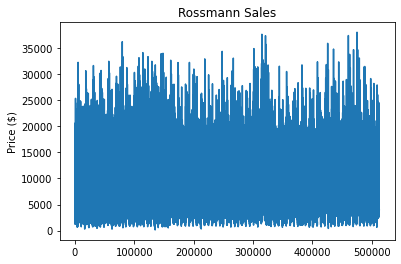

In [20]:
plt.plot(merged_data.index, merged_data['Sales'])
plt.title('Rossmann Sales')
plt.ylabel('Price ($)');
plt.show()

/var/folders/4v/cg5vs6j958l03gj1_w2prrhc0000gn/T/ipykernel_21751/2642529958.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  merged_data.hist(ax=ax)


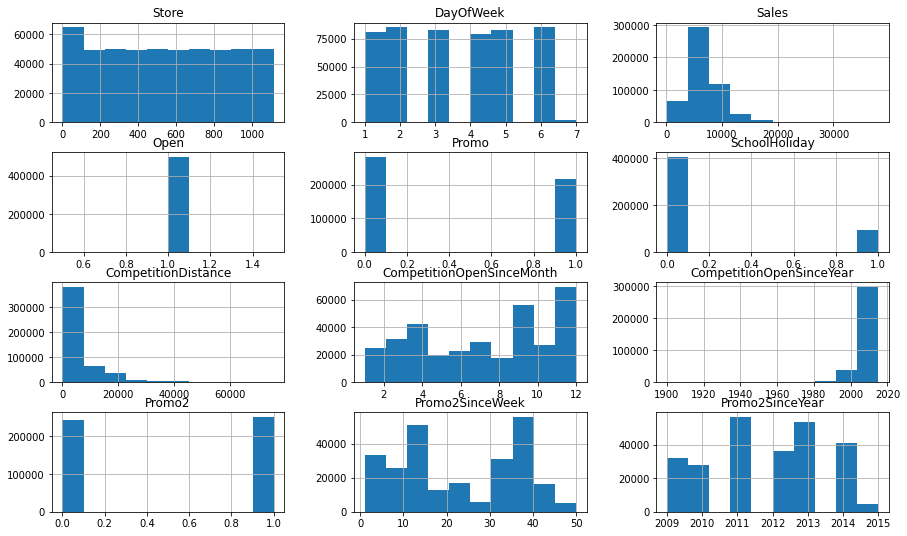

In [21]:
fig ,ax = plt.subplots(figsize=(15,9))
merged_data.hist(ax=ax)
plt.show()

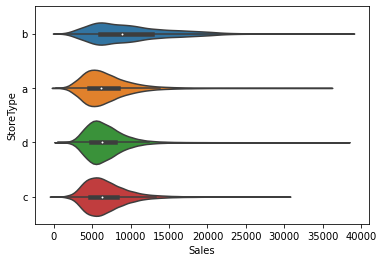

In [22]:
ax = sns.violinplot(x="Sales", y="StoreType", data=merged_data)

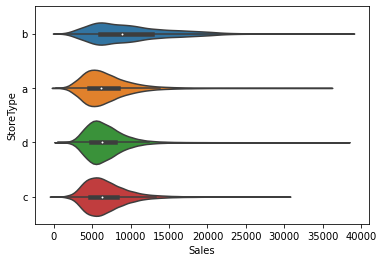

In [23]:
ax = sns.violinplot(x="Sales", y="StoreType", data=merged_data)

In [24]:
X_train = merged_data_train.loc[:, ~merged_data_train.columns.isin(["Sales"])]
y_train = merged_data_train.loc[:, "Sales"]

X_validation = merged_data_validation.loc[:, ~merged_data_validation.columns.isin(["Sales"])]
y_validation = merged_data_validation.loc[:, "Sales"]

X_test = merged_data_test.loc[:, ~merged_data_test.columns.isin(["Sales"])]
y_test = merged_data_test.loc[:, "Sales"]

Splitting results.

In [25]:
print(f"Our train set has {len(X_train)} samples")
print(f"Our validation set has {len(X_validation)} samples")
print(f"Our test set has {len(X_test)} samples")

Our train set has 355654 samples
Our validation set has 80183 samples
Our test set has 77119 samples


## Data profiling

The cell below is commented out for faster running of this notebook. The resulting profile report can be found by following the link below:

**[Rossmann profile report](files/rossmann_profile_report.html)**

In [26]:
# profile = ProfileReport(X_train)
# profile.to_file(output_file="rossmann_profile_report.html")

## Feature engineering

In [27]:
# fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
# sns.countplot(x='Weekday', hue='Storetype', data=X_train, palette="husl", ax=axis1)
# plt.show()

<font color='red'>It would be good to check amount of features missing per sample. If more than 50%, try dropping entire row.</font>

<font color='red'>It would be good to check for outliers.</font>

For each feature we applied the following changes:

**Date**
* Split feature into four features: year, month, week, day of week
* Encode month, week, and day of week with sine+cosine for circularity
* Drop the original feature

**DayOfWeek**
* Drop feature, will be replaced with values derived from Date

**Store**
* Applying target encoding
* Consideration of frequency encoding, depending on success of target encoding. May be changed after first tests.

<font color='red'>Should we still test frequency encoding? Or do we change this wording? "Target encoding proved very successful and gave this feature the highest importance in a single RandomForestRegressor."</font>

**Open**
* Two values available: 1 (True) and NaN. Therefore using zero imputation.
* If feature turns out to be unimportant (likely with ~3% NaNs), drop feature after first tests

<font color='red'>Are we dropping it?</font>

**Promo**
* Mode imputing ~3% of NaNs

**StateHoliday**
* Four categories
* Category 0.0 needs to be changed to "0"
* Mode imputing ~3% of NaNs
* Apply ordinal encoding because number of stores open is in goes in descending order: 0>a>b>c. This likely reflects overall store opening in the nation.

<font color='red'>It could be nice to check if a specific StoreType is open more often on StateHolidays or not.</font>

**SchoolHoliday**
* Mode imputing ~3% of NaNs

**StoreType**
* Mode imputing ~3%
* Ordinal encoding because 4 models, a-d, may very well relate to store size, e.g., large shopping mall store vs. small train station store.

**Assortment**
* Mode imputing ~3%
* Apply ordinal encoding because assortment is an ordinate: a = basic, b = extra, c = extended    
    
**CompetitionDistance**
* Applying median imputation to ~3% missing values

**CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**
* Merge and create new feature, giving temporal distance in days from sales date, and drop the original features
* Set negative days, i.e., days before competition opened, to 0
* First imputation: set NaNs to -1

<font color='red'>These last two points could be edited: add a True/False feature for missing values/negative days vs. SalesCompetitionLag</font>

**Promo2**
* Mode imputing ~3%
* All 1s (True) also have other information on Promo2
* When there is a NaN there is no information on a possible promotion. Though a promotion is not likely and 0 imputation could be good, we still choose mode imputation due to a lack of information.

**Promo2SinceWeek** and **Promo2SinceYear**
* Merge and create new feature, giving temporal distance in days from sales date, and drop the original features
* Set negative days, i.e., days before Promo2 started, to 0
* First imputation: set NaNs to -1

<font color='red'>Imputation of Stores not participating in Promo2 is caught by the boolean from the Promo2 feature. However, the last two points could be edited: add a True/False feature for missing values/negative days vs. Promo2Lag</font>

**PromoInterval**
* Mode imputed
* Apply one-hot encoding

<font color='red'>Same as Promo2SinceWeek and Promo2SinceYear. Would again be good to catch NaNs with the Promo2 feature</font>

<font color='red'>Or are we dropping this feature entirely?</font>

## Impute missing values

Following the considerations and strategies above, we first impute missing values.

In [28]:
imp = Imputer()
imp.define_imputers()
imp.fit(X_train)
X_train_transf = imp.transform_reconstruct(X_train)
X_test_transf = imp.transform_reconstruct(X_test)
X_validation_transf = imp.transform_reconstruct(X_validation)

## Clean data

With most values imputed, we follow the above considerations and strategies for further cleaning

In [29]:
clnr = Cleaner()
clnr.clean(X_train_transf)
X_train_clean = clnr.data
X_train_clean_dates = clnr.dates

clnr = Cleaner()
clnr.clean(X_validation_transf)
X_validation_clean = clnr.data
X_validation_clean_dates = clnr.dates

clnr = Cleaner()
clnr.clean(X_test_transf)
X_test_clean = clnr.data
X_test_clean_dates = clnr.dates

In [30]:
X_train_clean.shape

(355654, 18)

In [41]:
df['y_hats'] = y_hats2


0         3139.0
1         2401.0
2         2646.0
3         3113.0
4         2907.0
           ...  
355649    7084.0
355650    5098.0
355651    9265.0
355652    8393.0
355653    8873.0
Name: Sales, Length: 355654, dtype: float64

In [43]:
df = pd.concat([X_train, y_train])
df['Sales'] = y_train

In [45]:
df.to_csv('merged_data_clean.csv')

## Visualization of cleaned data

After the above steps, our data looks as follows.

In [33]:
X_train_clean.sample(10)

,Date,Store,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Weekday,Month_sin,Month_cos,Weekday_sin,Weekday_cos,SalesCompetitionLag,Promo2Lag
242479,2013-09-26,674,1.0,0,0.0,a,a,2640.0,1.0,2013,9,3,-1.000000e+00,-1.836970e-16,0.051620,0.998667,2856.0,53.0
339420,2014-01-14,749,0.0,0,0.0,a,a,3410.0,1.0,2014,1,1,5.000000e-01,8.660254e-01,0.017213,0.999852,897.0,0.0
314752,2013-12-16,300,1.0,0,0.0,a,c,120.0,1.0,2013,12,0,-2.449294e-16,1.000000e+00,0.000000,1.000000,1720.0,715.0
135830,2013-06-04,98,1.0,0,0.0,d,c,15140.0,1.0,2013,6,1,1.224647e-16,-1.000000e+00,0.017213,0.999852,2377.0,520.0
238318,2013-09-21,736,0.0,0,0.0,c,c,1650.0,1.0,2013,9,5,-1.000000e+00,-1.836970e-16,0.085965,0.996298,-1.0,902.0
84922,2013-04-05,1088,0.0,0,1.0,a,a,4300.0,1.0,2013,4,4,8.660254e-01,-5.000000e-01,0.068802,0.997630,1496.0,0.0
114212,2013-05-08,663,0.0,0,0.0,a,c,7860.0,0.0,2013,5,2,5.000000e-01,-8.660254e-01,0.034422,0.999407,2929.0,-1.0
182689,2013-07-24,969,0.0,0,0.0,a,c,600.0,1.0,2013,7,2,-5.000000e-01,-8.660254e-01,0.034422,0.999407,5014.0,136.0
24984,2013-01-29,418,0.0,0,0.0,a,a,1060.0,1.0,2013,1,1,5.000000e-01,8.660254e-01,0.017213,0.999852,1369.0,576.0
105480,2013-04-27,1115,0.0,0,0.0,d,c,5350.0,1.0,2013,4,5,8.660254e-01,-5.000000e-01,0.085965,0.996298,-1.0,335.0


In [34]:
import matplotlib.pyplot as plt


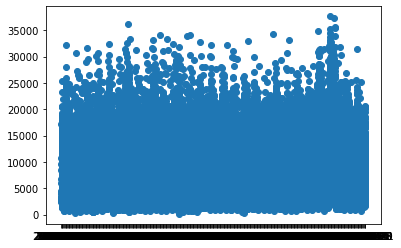

In [35]:
# plot Date column from X_train and Sales column from y_train
plt.scatter(X_train_clean_dates, y_train)
plt.show()

<font color='red'>It would be good to add some visualizations here.</font>

<font color='red'>Examples could be the time series with special highlights going to periods with high sales (e.g., Christmas)</font>

# Modeling

## Begin pipeline

We start with building a base-pipeline on which we can build our models. This base pipeline takes care of data encoding.

In [36]:
pipe = Pipeline([
    ("target_encoder", TargetEncoder(cols="Store")),
    ("ordinal_encoder", OrdinalEncoder(cols=["StateHoliday", "StoreType", "Assortment"])),
], verbose=True)

## Random forest

Our first attempt uses a single random forest regressor so that we can get a first glimpse of the importance of different features.

In [37]:
rfr = RandomForestRegressor(
    n_estimators=1024,
    max_depth=16,
    min_samples_split=32,
    n_jobs=-1,
    random_state=42,
)

rfpipe = pipe

rfpipe.steps.append(['rfr', rfr])

<font color='red'>Interestingly, adding the Week_sin and Week_cos features had a horrible effect on the model, taking the score up from 19.7 to ~27! What do we do?</font>

In [38]:
rfpipe.fit(X_train_clean, y_train)
#rfpipe.fit(X_train_clean.drop(labels=["Week_sin", "Week_cos"], axis=1), y_train)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[Pipeline] .... (step 1 of 3) Processing target_encoder, total=   0.1s
[Pipeline] ... (step 2 of 3) Processing ordinal_encoder, total=   0.1s


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
y_pred = rfpipe.predict(X_validation_clean)
#y_pred = rfpipe.predict(X_validation_clean.drop(labels=["Week_sin", "Week_cos"], axis=1))

In [ ]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.values.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [ ]:
metric(y_pred, y_validation)

In [ ]:
 n_estimators=1024,
    max_depth=16,
    min_samples_split=32,
    n_jobs=-1,
    random_state=42,

In [ ]:
# dropped Open, PromoInterval, 
# dropped Week_sin, Week_cos
#   n_estimators=1024,
#     max_depth=32,
#     min_samples_split=32,
#     n_jobs=-1,
#     random_state=42,
    
#     19.625869037388814


In [ ]:
# dropped Week_sin, Week_cos
#     n_estimators=512,
#     max_depth=8,
#     min_samples_split=16,
#     n_jobs=-1,
#     random_state=42,
# )
# 24.231677863136422


In [ ]:
# dropped Week_sin, Week_cos
# n_estimators=512,
#     max_depth=8,
#     min_samples_split=16,
#     n_jobs=-1,
#     random_state=0,

# 24.226454063190513

In [ ]:
# dropped Week_sin, Week_cos
# n_estimators=1024,
#     max_depth=16,
#     min_samples_split=32,
#     n_jobs=-1,
#     random_state=42,

# 19.602686717730144

In [ ]:
# dropped Week_sin, Week_cos
# n_estimators=1024,
#     max_depth=8,
#     min_samples_split=16,
#     n_jobs=-1,
#     random_state=42,


#  24.24530735315937

In [ ]:
# 19.689037516898324

In [ ]:
# 19.337539508342996

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y_validation, y_pred, '.')
plt.show()

In [ ]:
importances = pd.DataFrame({
    "features": rfpipe.steps[3][1].feature_names_in_,
    "values": rfpipe.steps[3][1].feature_importances_,
})

print(importances.sort_values(by="values", ascending=False))

importances.set_index("features").sort_values(by="values", ascending=False).plot.barh()